## plotNWT_hillslope_simple
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

In [4]:
cluster

### Point to files

In [93]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
site  = ['DM','MM']
longSite  =  ['dry meadow','moist meadow']#'dry_meadow'
#case  =  ['NEON_NIWO_hh_test']
case  =  ['NEON_NIWO_3col_dm01','NEON_NIWO_3col_mm01']
rollHour = -12  
years = range(241,242)
nmon  = 12

#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)

#dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
dirIn = ['/glade/scratch/wwieder/'+case[c]+'/run/' for c in range(len(case))]
dmfiles = [dirIn[0] + case[0] +'.clm2.h1.0'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
mmfiles = [dirIn[1] + case[1] +'.clm2.h1.0'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
print(dmfiles[0])
print(mmfiles[0])

/glade/scratch/wwieder/NEON_NIWO_3col_dm01/run/NEON_NIWO_3col_dm01.clm2.h1.0241-01-01-00000.nc
/glade/scratch/wwieder/NEON_NIWO_3col_mm01/run/NEON_NIWO_3col_mm01.clm2.h1.0241-01-01-00000.nc


--- 
### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [94]:
%%time
ds_dm = utils.time_set_mid(xr.open_mfdataset(dmfiles, decode_times=True, combine='by_coords'), 'time')
ds_mm = utils.time_set_mid(xr.open_mfdataset(mmfiles, decode_times=True, combine='by_coords'), 'time')
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 1.11 s, sys: 66.3 ms, total: 1.18 s
Wall time: 1.86 s


#### Combine pft and column coordinates
#### Then combine datasets 

In [95]:
ds_dm = ds_dm.rename({'pft':'column'})
ds_mm = ds_mm.rename({'pft':'column'})
ds = ds_dm.where(ds_dm.column==2, ds_mm)
ds.GPP

<xarray.DataArray 'GPP' (time: 17520, column: 3)>
dask.array<where, shape=(17520, 3), dtype=float32, chunksize=(17520, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0240-12-31 23:45:00 ... 0241-12-31 23:15:00
Dimensions without coordinates: column
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [96]:
ds = ds.assign_coords({"column": ["mm", "wm", "dm"]})

### Sample surface dataset has 
- 4 aspects [0:2], [3:5], [6:8] & [9:11], which corresponded to `hslp_index` 
- 3 elevation classes low = [0,3,6,9], high = [2,5,8,11]
- all columns have arctic C3 grass
- not sure what `hslp_cold` is about, but it seems to have missing values for the highest elevation columns.  Also, lateral flow is more regular from these columns (see plot below)

In [97]:
print(ds.hslp_aspect.values)
print()
print(ds.hslp_elev.values)
print()
print(ds.pfts1d_itype_veg.values)
print()
print(ds.hslp_cold.values)
print()
print(ds.cols1d_nbedrock.values)

[1.57079633 0.         4.71238898]

[3.75 0.75 3.75]

[12. 12. 12.]

[    2 -9999     2]

[10.  9.  9.]


In [98]:
print(ds.cols1d_wtgcell.values)
ds.GPP

[0.42857143 0.14285714 0.42857143]


<xarray.DataArray 'GPP' (time: 17520, column: 3)>
dask.array<where, shape=(17520, 3), dtype=float32, chunksize=(17520, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0240-12-31 23:45:00 ... 0241-12-31 23:15:00
  * column   (column) <U2 'mm' 'wm' 'dm'
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [ ]:
plt.figure(figsize=[12,8])
plt.subplot(221)
ds.SNOW_DEPTH.plot(hue='column') 
plt.subplot(222)
ds.isel(levsoi=2).H2OSOI.plot(hue='column');

plt.subplot(223)
ds.QLATFLOWOUT.resample(time='D').mean('time').plot(hue='column') ;
plt.subplot(224)
ds.QDISCHARGE.resample(time='D').mean('time').plot(hue='column') ;


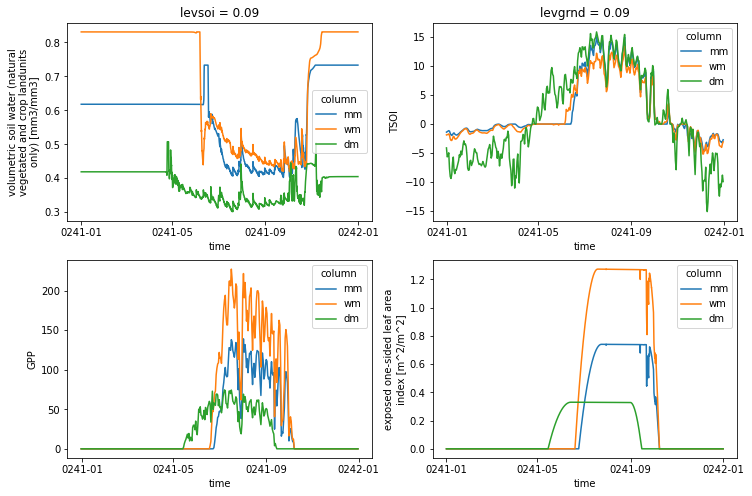

In [101]:
plt.figure(figsize=[12,8])

plt.subplot(221)
ds.isel(levsoi=2).H2OSOI.plot(hue='column');
plt.subplot(222)
(ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).plot(hue='column');
plt.subplot(223)
(ds.GPP.resample(time='D').mean('time')*365*3600).plot(hue='column') ; #gC/m2/d
plt.subplot(224)
ds.ELAI.plot(hue='column');

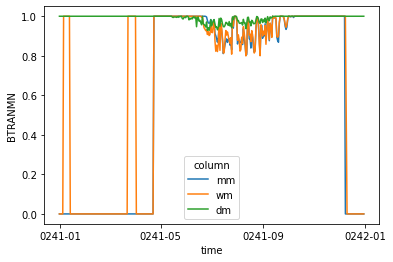

In [102]:
ds.BTRANMN.resample(time='D').mean('time').plot(hue='column') ; #.plot(hue='pft');
#ds.QDISCHARGE.isel(column=0).groupby('time.dayofyear').sum().values

In [103]:
print(ds.GPP.attrs['units'])
(ds.GPP.resample(time='Y').mean('time')*365*24*3600).values

gC/m^2/s


array([[  0.     ,   0.     ,   0.     ],
       [579.11304, 968.6429 , 362.95105]], dtype=float32)

In [76]:
# Reverse axes here
ds['levsoi'] = ds.levsoi * -1

In [77]:
ds.levsoi 

<xarray.DataArray 'levsoi' (levsoi: 20)>
array([-0.01, -0.04, -0.09, -0.16, -0.26, -0.4 , -0.58, -0.8 , -1.06, -1.36,
       -1.7 , -2.08, -2.5 , -2.99, -3.58, -4.27, -5.06, -5.95, -6.94, -8.03],
      dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 -0.01 -0.04 -0.09 -0.16 ... -5.95 -6.94 -8.03

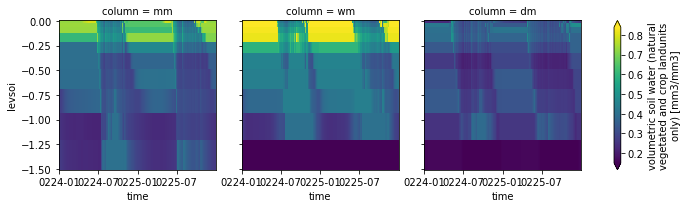

In [78]:
g_simple = ds.H2OSOI.isel(levsoi=slice(0,10)).plot(x="time", y="levsoi", col="column", col_wrap=3, robust=True)

In [79]:
ds['levgrnd'] = ds.levgrnd * -1

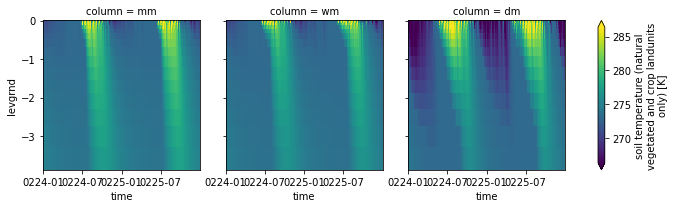

In [80]:
g_simple = ds.isel(levgrnd=slice(0,15)).TSOI.plot(x="time", y="levgrnd", col="column", col_wrap=3, robust=True)